# Test Audio Samples - 16kHz Models

In [135]:
import os
import torchaudio
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from fnmatch import fnmatch
from pathlib import Path
from scipy.fft import fft, fftfreq
from scipy import signal

from matplotlib.ticker import ScalarFormatter, LogLocator
%matplotlib inline

In [143]:
torchaudio.backend.set_audio_backend("soundfile")
torchaudio.get_audio_backend()

'soundfile'

In [124]:
sample_rate = 16000

start = 16000
end = 16500
SAMPLES_DIR = Path("results/audio-batches")

In [125]:
def check_dc_offset(pred, target):
    pred_offset = pred.mean()
    target_offset = target.mean()
    dc_offset = pred_offset - target_offset

    # Smallest quantization step for 16-bit audio
    quantization_step_16bit = 1 / 32767.0

    # Check if the absolute value of the DC offset is smaller or larger than the quantization step
    if abs(dc_offset) < quantization_step_16bit:
        print("The DC offset is smaller than the smallest quantization step for 16-bit audio.")
    else:
        print("The DC offset is larger than the smallest quantization step for 16-bit audio.")

In [126]:
def overlap_waveforms(o, t, sample_rate, start, end, title):    

    o_zoom = o[start:end]
    t_zoom = t[start:end]

    # create time vector
    time = range(start, end)

    plt.figure(figsize=(12,3))
    plt.plot(time, o_zoom, alpha=0.8, label="Model")
    plt.plot(time, t_zoom, alpha=0.8, label="Target")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.title(title)
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.savefig(f"results/plots/{title}_waves.png")
    plt.show()

def two_spectrograms_difference(o, t, sample_rate, title):

    N = len(o)                   # Number of sample points
    T = 1.0 / sample_rate        # sample spacing

    # Apply Hann window
    windowed_o = o * signal.windows.hann(N)
    windowed_t = t * signal.windows.hann(N)

    o_yf = fft(windowed_o)
    t_yf = fft(windowed_t)
    
    xf = fftfreq(N, 1/sample_rate)[:N//2]

    # Convert magnitude to dB scale
    o_mag_in_db = 20 * np.log10(np.abs(o_yf[:N//2]))
    t_mag_in_db = 20 * np.log10(np.abs(t_yf[:N//2]))

    plt.figure(figsize=(12,4))
    plt.plot(xf, o_mag_in_db, linewidth=0.5, alpha=.6, label="Model")
    plt.plot(xf, t_mag_in_db, linewidth=0.5, alpha=.6, label="Target")
    plt.plot
    plt.grid()
    plt.xlim(20, sample_rate/2)
    plt.ylim(-120, np.max(o_mag_in_db)+10)
    plt.xscale('log')
    plt.title(title)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Magnitude (dB)')
    plt.legend()
    
    # Use ScalarFormatter to avoid scientific notation
    ax = plt.gca()
    ax.xaxis.set_major_formatter(ScalarFormatter())
    ax.xaxis.get_major_formatter().set_scientific(False)
    ax.xaxis.get_major_formatter().set_useOffset(False)
    plt.tight_layout()
    plt.savefig(f"results/plots/{title}_spectra.png")
    plt.show()

AudioMetaData(sample_rate=16000, num_frames=512000, num_channels=1, bits_per_sample=32, encoding=PCM_F)


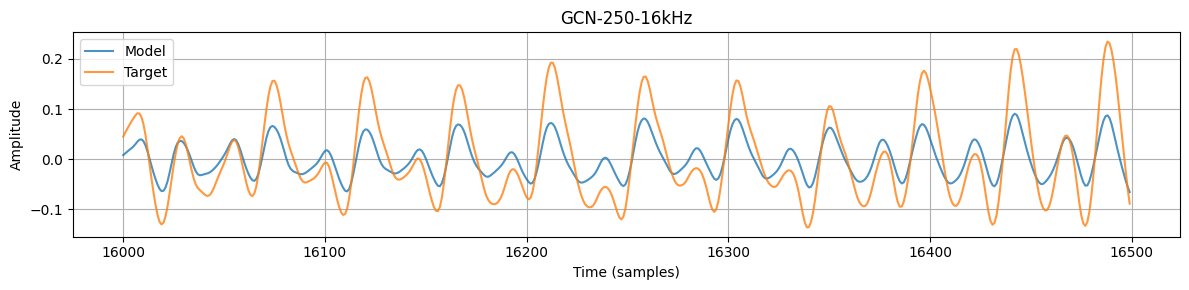

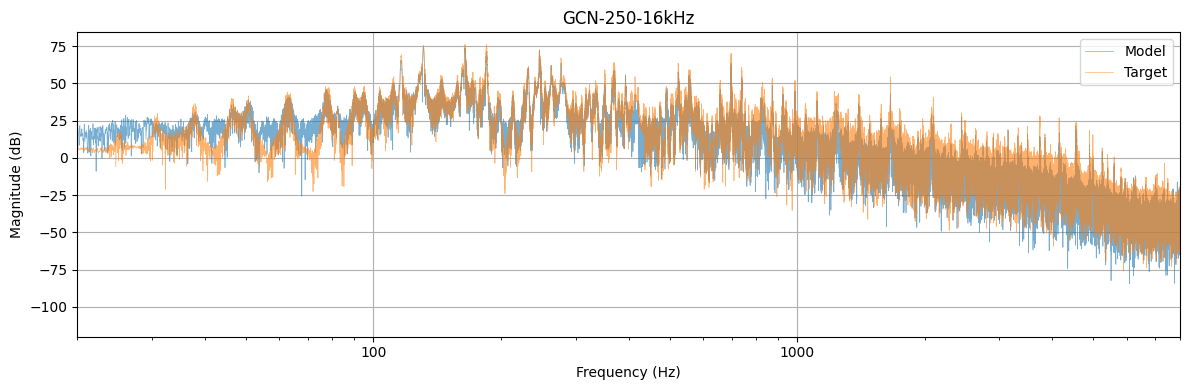

The DC offset is smaller than the smallest quantization step for 16-bit audio.


In [134]:
o_p, sample_rate = torchaudio.load(SAMPLES_DIR / "out_gcn-250.wav")
metadata = torchaudio.info(SAMPLES_DIR / "out_gcn-250.wav")
print(metadata)

t_p, t_sr = torchaudio.load(SAMPLES_DIR / "tgt_gcn-250.wav")

o = o_p.numpy().squeeze()
t = t_p.numpy().squeeze()

title = "GCN-250-16kHz"

overlap_waveforms(o, t, sample_rate, start, end, title)
two_spectrograms_difference(o, t, sample_rate, title)
check_dc_offset(o, t)

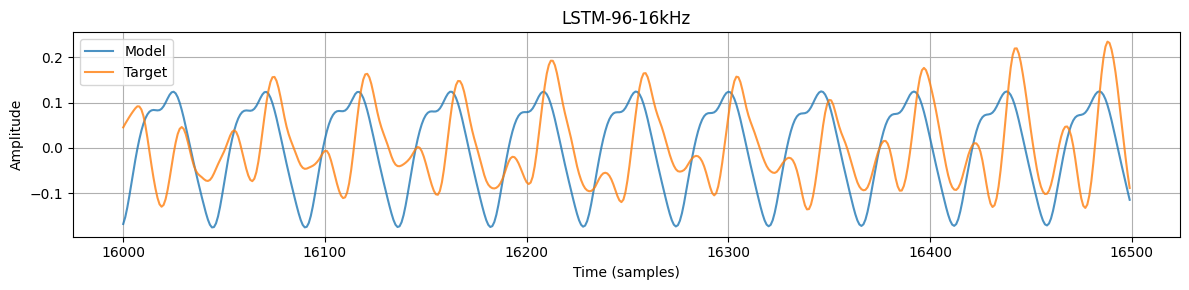

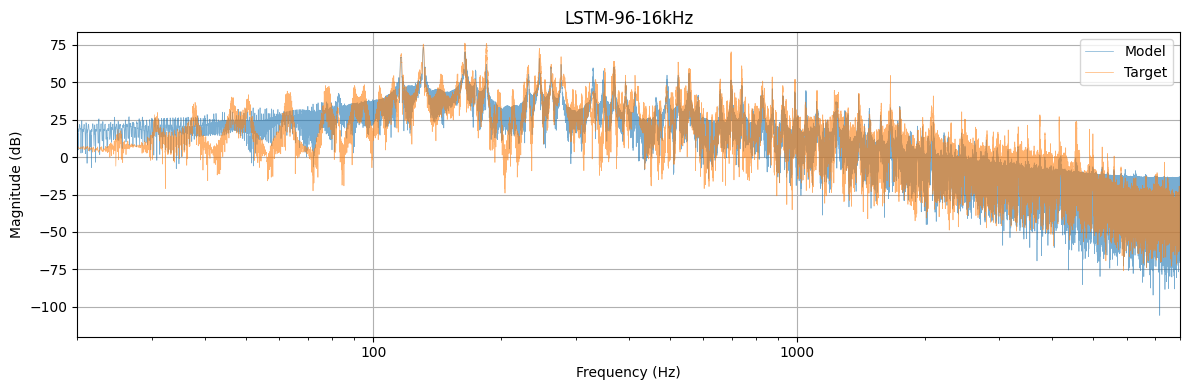

The DC offset is smaller than the smallest quantization step for 16-bit audio.


In [128]:
title = "LSTM-96-16kHz"

o_lstm_96_leg, _ = torchaudio.load(SAMPLES_DIR / "out_LSTM-96.wav")
t_lstm_96_leg, _ = torchaudio.load(SAMPLES_DIR / "tgt_LSTM-96.wav")

o = o_lstm_96_leg.numpy().squeeze()
t = t_lstm_96_leg.numpy().squeeze()

overlap_waveforms(o, t, sample_rate, start, end, title)
two_spectrograms_difference(o, t, sample_rate, title)
check_dc_offset(o, t)

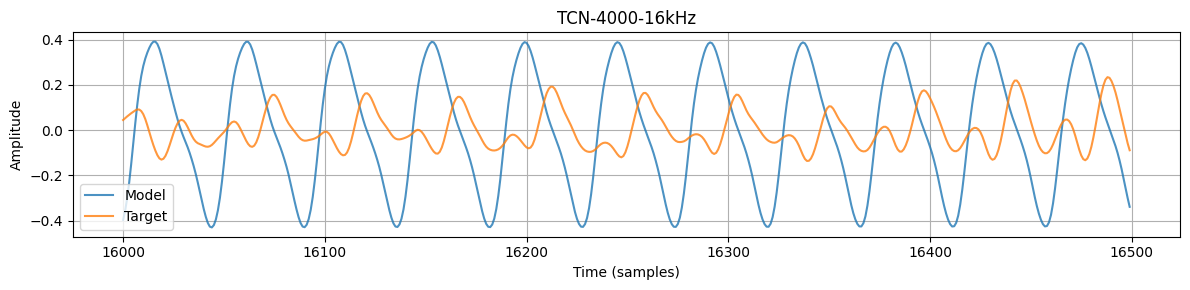

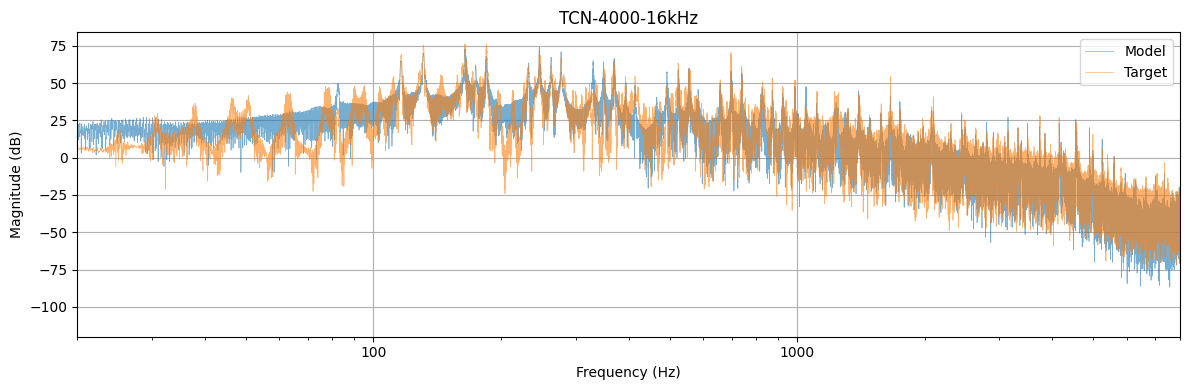

The DC offset is smaller than the smallest quantization step for 16-bit audio.


In [129]:
title = "TCN-4000-16kHz"

o_tcn, _ = torchaudio.load(SAMPLES_DIR / "out_tcn-4000.wav")
t_tcn, _ = torchaudio.load(SAMPLES_DIR / "tgt_tcn-4000.wav")

o = o_tcn.numpy().squeeze()
t = t_tcn.numpy().squeeze()


overlap_waveforms(o, t, sample_rate, start, end, title)
two_spectrograms_difference(o, t, sample_rate, title)
check_dc_offset(o, t)

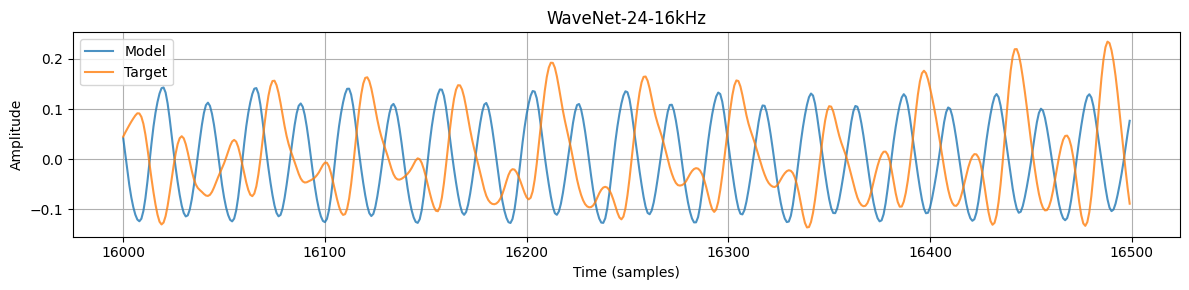

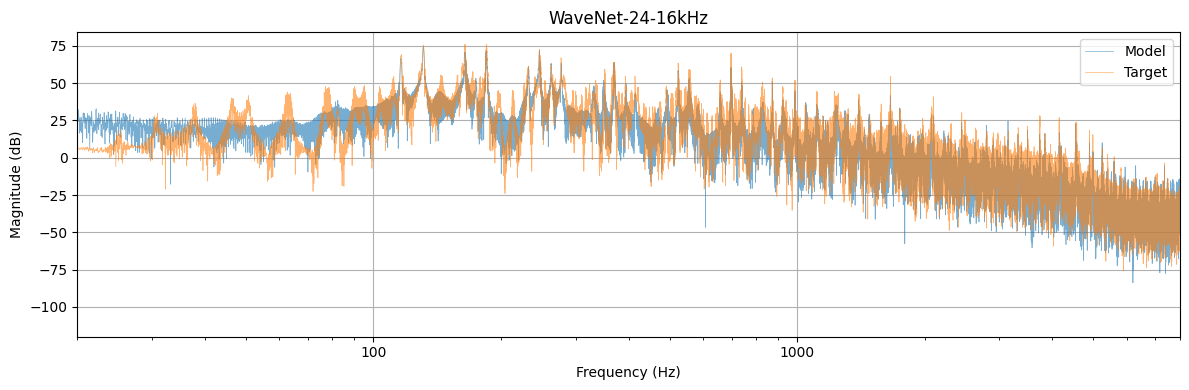

The DC offset is larger than the smallest quantization step for 16-bit audio.


In [130]:
o_p, sample_rate = torchaudio.load(SAMPLES_DIR / "out_wavenet-24.wav")
t_p, t_sr = torchaudio.load(SAMPLES_DIR / "tgt_wavenet-24.wav")

o = o_p.numpy().squeeze()
t = t_p.numpy().squeeze()

title = "WaveNet-24-16kHz"

overlap_waveforms(o, t, sample_rate, start, end, title)
two_spectrograms_difference(o, t, sample_rate, title)

check_dc_offset(o, t)

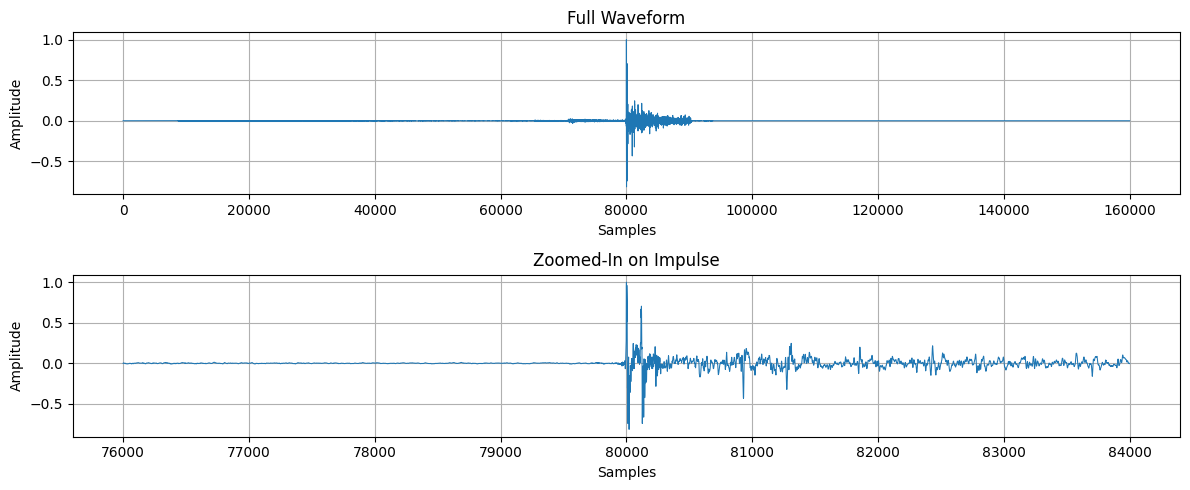

In [131]:
data, sample_rate = torchaudio.load("results/measured_IR/audio/gcn-250-16.0k-1_IR.wav")
data = data.numpy().squeeze()

def plot_impulse_with_zoom(data, sample_rate, zoom_factor=0.5):
    """
    Plot the waveform and zoom in on the impulse.

    Parameters:
    - data: The impulse signal data.
    - sample_rate: The sample rate of the data.
    - zoom_factor: The fraction of the total duration to show around the impulse.
    """

    # Identify where the impulse is (find the sample with the highest absolute amplitude)
    impulse_index = np.argmax(np.abs(data))

    # Compute the number of samples to show around the impulse for zooming
    samples_to_show = int(sample_rate * zoom_factor)

    # Define start and end indices for the zoomed view
    start_index = max(0, impulse_index - samples_to_show // 2)
    end_index = min(len(data) - 1, impulse_index + samples_to_show // 2)

    # Create plots
    fig, axs = plt.subplots(2, 1, figsize=(12, 5))

    # Full waveform
    axs[0].plot(data, linewidth=0.75)
    axs[0].set_title("Full Waveform")
    axs[0].set_xlabel("Samples")
    axs[0].set_ylabel("Amplitude")
    axs[0].grid()

    # Zoomed-in waveform
    axs[1].plot(range(start_index, end_index), data[start_index:end_index], linewidth=0.75)
    axs[1].set_title("Zoomed-In on Impulse")
    axs[1].set_xlabel("Samples")
    axs[1].set_ylabel("Amplitude")
    axs[1].grid()

    plt.tight_layout()
    plt.show()

# Test with the impulse signal from the previous code snippet
plot_impulse_with_zoom(data, sample_rate)

In [132]:
def plot_impulse_and_spectrogram(data, sample_rate, zoom_factor=0.1):
    """
    Plot the waveform, zoom in on the impulse, and display its traditional spectrogram.

    Parameters:
    - data: The impulse signal data.
    - sample_rate: The sample rate of the data.
    - zoom_factor: The fraction of the total duration to show around the impulse.
    """
    # Identify where the impulse is (find the sample with the highest absolute amplitude)
    impulse_index = np.argmax(np.abs(data))

    # Compute the number of samples to show around the impulse for zooming
    samples_to_show = int(sample_rate * zoom_factor)

    # Define start and end indices for the zoomed view
    start_index = max(0, impulse_index - samples_to_show // 2)
    end_index = min(len(data) - 1, impulse_index + samples_to_show // 2)

    # Extract zoomed data
    zoomed_data = data[start_index:end_index]

   # Compute the spectrogram of the zoomed data with a larger window for better frequency resolution
    nperseg = int(0.02 * sample_rate)  # Window size, for example, 0.02 sec
    f, t, Sxx = signal.spectrogram(zoomed_data, fs=sample_rate, nperseg=nperseg, noverlap=nperseg//2)

    # Create plots
    fig, axs = plt.subplots(3, 1, figsize=(12, 8))

    # Full waveform
    axs[0].plot(data)
    axs[0].set_title("Full Waveform")
    axs[0].set_xlabel("Samples")
    axs[0].set_ylabel("Amplitude")
    axs[0].grid()

    # Zoomed-in waveform
    axs[1].plot(range(start_index, end_index), zoomed_data)
    axs[1].set_title("Zoomed-In on Impulse")
    axs[1].set_xlabel("Samples")
    axs[1].set_ylabel("Amplitude")
    axs[1].grid()

    # Traditional spectrogram
    cmap = plt.get_cmap('inferno')
    Sxx_dB = 10 * np.log10(Sxx)
    min_magnitude = np.max(Sxx_dB) - 60  # Dynamic range of 60 dB
    img = axs[2].pcolormesh(t, f, Sxx_dB, shading='gouraud', cmap=cmap, vmin=min_magnitude)
    axs[2].set_yscale('log')  # Logarithmic scale for frequencies
    axs[2].set_ylim(f[1], f[-1])  # Exclude DC (0 Hz)
    fig.colorbar(img, ax=axs[2], label="Magnitude [dB]")
    axs[2].set_title("Spectrogram")
    axs[2].set_ylabel("Frequency [Hz]")
    axs[2].set_xlabel("Time [sec]")
    axs[2].grid()

    axs[2].set_title("Spectrogram")
    axs[2].set_ylabel("Frequency [Hz]")
    axs[2].set_xlabel("Time [sec]")
    axs[2].grid()

    plt.tight_layout()

    plt.show()

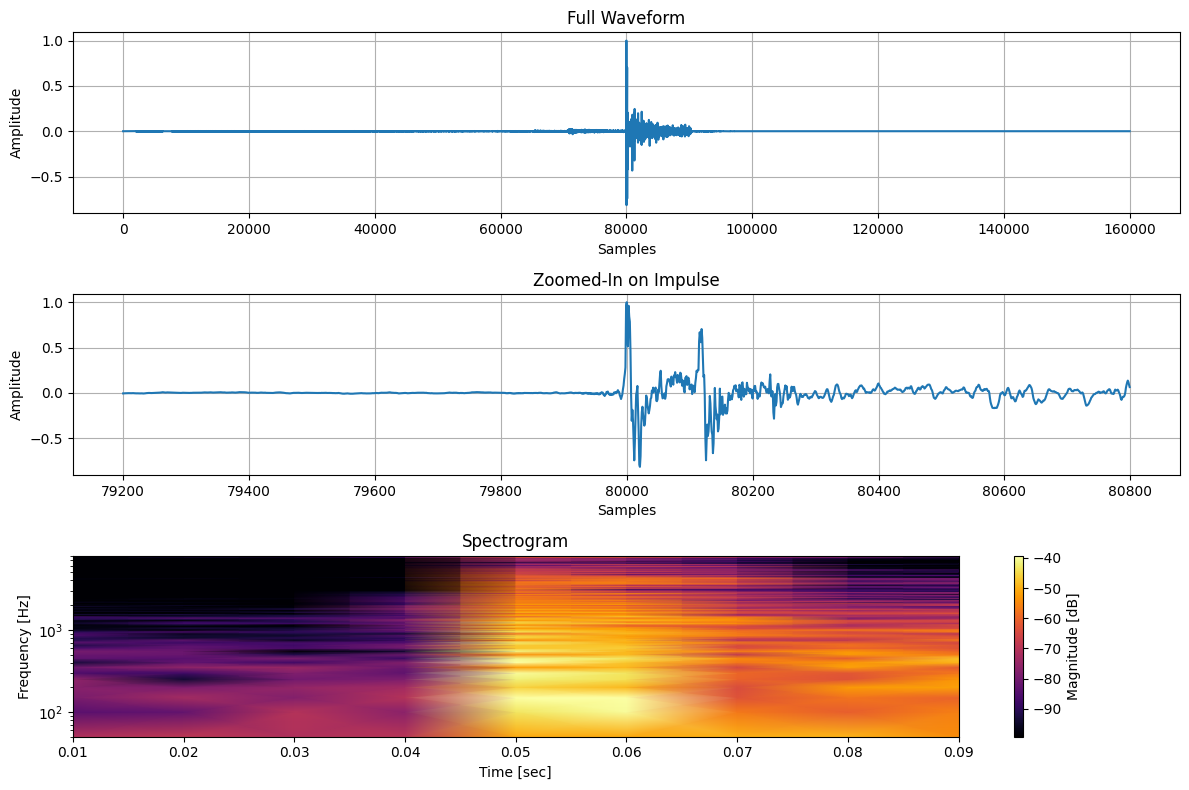

In [133]:
plot_impulse_and_spectrogram(data, sample_rate)